# Data process

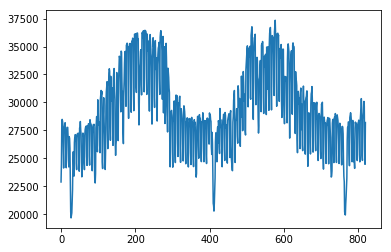

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv').set_index(['日期'])
data = df.iloc[:, 1]
plt.plot(np.arange(data.shape[0]), data, label='pred')
plt.show()

* 發現周末的電力相比一到五通常較低，在圖上會呈現一個周期性的波型
* 在過年期間的最大負載會急遽降低

# Class of dataset
* 輸入60天預測7天
* 使用**最大負載**和**周末與否**
* 對**最大負載**進行正規化
* Train/Val 3:1(最後1/4作為Val)

In [2]:
from electric_dataset_pd import electric_dataset

FeatureList = [1, -4]
IgnoreNorList = [-4]
preday = 60
train_dataset = electric_dataset('data.csv', preday, feature=FeatureList, ignore_nor=IgnoreNorList, ratio=4)
val_dataset = electric_dataset('data.csv', preday, feature=FeatureList, randomlist=train_dataset.randomlist, training=False)
print('Train data:')
print(train_dataset.loads[0])
print('Val data:')
print(val_dataset.loads[0])

Train data:
[array([[-0.3659991 ,  1.        ],
       [-0.27566594,  0.        ],
       [-0.06931943,  0.        ],
       [-0.04929567,  0.        ],
       [-0.05772375,  0.        ],
       [-0.07661622,  0.        ],
       [-0.21248363,  1.        ],
       [-0.29546344,  1.        ],
       [-0.09539556,  0.        ],
       [-0.08877754,  0.        ],
       [-0.07718186,  0.        ],
       [-0.06620839,  0.        ],
       [-0.12418679,  0.        ],
       [-0.26192082,  1.        ],
       [-0.29416246,  1.        ],
       [-0.11236485,  0.        ],
       [-0.08985226,  0.        ],
       [-0.08985226,  0.        ],
       [-0.08985226,  0.        ],
       [-0.13957227,  0.        ],
       [-0.25179581,  1.        ],
       [-0.28997671,  1.        ],
       [-0.1365178 ,  0.        ],
       [-0.14579434,  0.        ],
       [-0.19523153,  0.        ],
       [-0.358872  ,  0.        ],
       [-0.51713888,  0.        ],
       [-0.54779672,  1.        ],
       

# Model and Train detail
* LSTM
    * Learning rate: 1e-3, decay by 0.1 when epoch == 10
    * Optimizer: Adam
    * Loss: L2 loss
* Learning Regression
* Save pretrain weigth: lstm.params, RGM.pickle

In [3]:
from Net import lstm
model = lstm()
from sklearn.linear_model import LinearRegression
LRmodel = LinearRegression()

# Forecasting

In [4]:
import mxnet as mx
import pickle
def normalize(data, FeatureList, IgnoreNorList, nor_params):
    tmp = []
    for idx, feature in enumerate(FeatureList):
        if feature in IgnoreNorList:
            load = data.iloc[:, feature]
        else:
            load = (data.iloc[:, feature] - nor_params[2]) / (nor_params[0] - nor_params[1])
        tmp.append(load)
    data = np.concatenate(tmp).reshape(-1, data.shape[0]).transpose()
    return data

In [5]:
df = pd.read_csv('data.csv').set_index(['日期'])
Preday = 60
data = df.iloc[Preday * -1:]
nor_params = np.array([37351, 19672, 29378.2126])
data = normalize(data, FeatureList, IgnoreNorList, nor_params)
ctx = mx.gpu()
x = mx.ndarray.array(data, ctx=ctx).transpose().expand_dims(0)

# First model
model.load_parameters('test.params')
model.collect_params().reset_ctx(ctx)

pred = model(x).asnumpy().reshape(-1)
pred = np.round((pred * (nor_params[0] - nor_params[1])) + nor_params[2]).astype('int32')

# Second model
with open('LRM.pickle', 'rb') as f:
    LRmodel = pickle.load(f)
    x = np.array(pred[2:4]).reshape(-1, 1)
    pred_holiday = LRmodel.predict(x).reshape(-1)
    pred[2:4] = pred_holiday
print(pred)

[28064 28339 25481 25481 25669 24672 28929]


# Save the predict values to csv file

In [6]:
Date = ['20190402', '20190403', '20190404', '20190405', '20190406', '20190407', '20190408']
df = pd.DataFrame({'date': Date, 'peak_load(MW)': pred})
df.to_csv('submission.csv', index=False)